In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [3]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os

In [2]:
#os.chdir('/content/drive/My Drive/face_mask_detection_alert_system')
Dataset='Dataset'
Data_Dir=os.listdir(Dataset)
print(Data_Dir)


['without_mask', 'with_mask']


In [3]:
#importing libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows,img_cols = 122, 122

images =[]
labels =[]

for category in Data_Dir:
    folder_path = os.path.join(Dataset,category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path,img)
        img = cv2.imread(img_path)

        try:
            ### Converting the image into gray scale
            grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            ### resizing the gray scaled image into size 56*56 in order to keep size of the images consistent

            resized_img = cv2.resize(grayscale_img,(img_rows,img_cols))
            images.append(resized_img)
            labels.append(category)

        except Exception as e:
            print('Exception:',e)

images = np.array(images)/255.0
images = np.reshape(images,(images.shape[0],img_rows,img_cols,1))

## Performing one hot encoding on labels since the labels are in textual format

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X, test_X,train_y,test_y) = train_test_split(images,labels,test_size=0.25,random_state=0)

In [4]:
### Importing Keras libraries for building a convolutional neural network
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

In [5]:
# Defining the model parameters
num_classes = 2
batch_size = 32

## Building CNN MODEL
model = Sequential()

## First layer grou containing Convolution, Relu, MaxPooling Layers
model.add(Conv2D(64,(3,3),input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

## Second Layer group containing Convolution, Relu and MaxPooling Layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

## Third Layer group containing Convolution, Relu and MaxPooling Layers
model.add(Conv2D(256,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

## Flatten and Dropout layers to stack the outpot convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

##Softmac classfier for output layer
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 58, 58, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 256)       8

In [7]:
### Plotting the model
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='face_mask_detection_architecture.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
### training the model

from keras.optimizers import Adam

epochs =50

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

fitted_model = model.fit(train_X,train_y,epochs=epochs,validation_split=0.25)

Epoch 1/50
14/14 [==============================] - 42s 3s/step - loss: 0.7695 - accuracy: 0.4932 - val_loss: 0.6966 - val_accuracy: 0.4694
Epoch 2/50
14/14 [==============================] - 47s 3s/step - loss: 0.6915 - accuracy: 0.4909 - val_loss: 0.6949 - val_accuracy: 0.4694
Epoch 3/50
14/14 [==============================] - 43s 3s/step - loss: 0.6327 - accuracy: 0.6096 - val_loss: 0.5367 - val_accuracy: 0.7619
Epoch 4/50
10/14 [====================>.........] - ETA: 11s - loss: 0.5416 - accuracy: 0.7437

KeyboardInterrupt: 

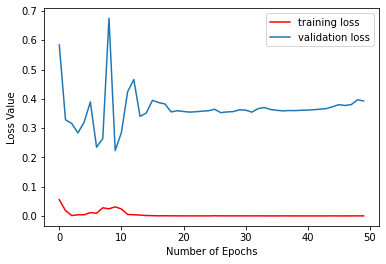

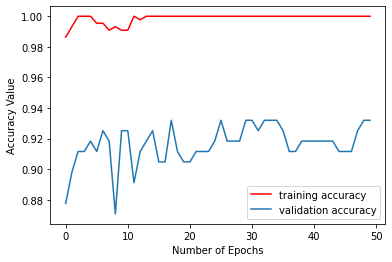

In [28]:
### Plotting the training loss and accuracy

import matplotlib.pyplot as plt
# Plot Training and validation Loss

plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()


In [29]:
## Saving the model
model.save('face_mask_detection_alert_system.h5')